# Classificação de Notícias do 20 news Group

https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

**Tarefa**: Receber uma notícia e prever qual é a sua categoria.

**Técnica utilizada**: Bidirectional LSTM ajustada para um problema de classificação multiclasse.

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import re
from sklearn.metrics import classification_report

Como baixar separadamente os dados de treinamento e de teste no 20 newsgroups:

In [41]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [42]:
len(newsgroups_train.data)

11314

In [43]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [44]:
cats = ['comp.graphics', 'talk.politics.misc','rec.autos','sci.electronics']

In [45]:
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test', categories=cats)

In [46]:
len(newsgroups_train.data)

2234

In [47]:
len(newsgroups_test.data)

1488

Observe que o vetor target mostra as categorias já em valores inteiros dentro de um numpy array:

In [48]:
newsgroups_train.target

array([1, 0, 2, ..., 2, 3, 3])

In [49]:
num_classes = len(np.unique(newsgroups_train.target_names))
num_classes

4

In [50]:
sentence = newsgroups_train.data[1]
sentence

'From: scott@osi.com (Scott Fleming)\nSubject: Sun IPX root window display - background picture\nKeywords: sun ipx background picture\nOrganization: Objective Systems Integrators, Folsom Ca.\nLines: 22\n\n\nHello netters!\n \nI have a fairly weak question to ask everybody in netland.  I\'ve looked though\nthe last FAQ for comp.graphics but I didn\'t find my answer.  Thus the post.\n \nI\'ll keep it short.\n \nQUESTION:  How do I display any raster files, gif files, iff or tiff images\nthat I have on my "root window" or background?  I have a sun ipc, openwindows\n3.0, Sun OS 4.1.3 if that helps any.\n \nI\'ve compiled POV for the sun and would like to display some of the work I have\ndone as a background/tile.  Thanks for any help or information that you\nprovide.  Have a good day.\n \nScott Fleming\nOSI\n \nP.S.\nKudo\'s to the people who provided POV, its great!\n\n'

In [51]:
result = re.sub('\n',' ',sentence)
result

'From: scott@osi.com (Scott Fleming) Subject: Sun IPX root window display - background picture Keywords: sun ipx background picture Organization: Objective Systems Integrators, Folsom Ca. Lines: 22   Hello netters!   I have a fairly weak question to ask everybody in netland.  I\'ve looked though the last FAQ for comp.graphics but I didn\'t find my answer.  Thus the post.   I\'ll keep it short.   QUESTION:  How do I display any raster files, gif files, iff or tiff images that I have on my "root window" or background?  I have a sun ipc, openwindows 3.0, Sun OS 4.1.3 if that helps any.   I\'ve compiled POV for the sun and would like to display some of the work I have done as a background/tile.  Thanks for any help or information that you provide.  Have a good day.   Scott Fleming OSI   P.S. Kudo\'s to the people who provided POV, its great!  '

In [52]:
result = re.sub(r'\\',' ',result)
result

'From: scott@osi.com (Scott Fleming) Subject: Sun IPX root window display - background picture Keywords: sun ipx background picture Organization: Objective Systems Integrators, Folsom Ca. Lines: 22   Hello netters!   I have a fairly weak question to ask everybody in netland.  I\'ve looked though the last FAQ for comp.graphics but I didn\'t find my answer.  Thus the post.   I\'ll keep it short.   QUESTION:  How do I display any raster files, gif files, iff or tiff images that I have on my "root window" or background?  I have a sun ipc, openwindows 3.0, Sun OS 4.1.3 if that helps any.   I\'ve compiled POV for the sun and would like to display some of the work I have done as a background/tile.  Thanks for any help or information that you provide.  Have a good day.   Scott Fleming OSI   P.S. Kudo\'s to the people who provided POV, its great!  '

In [53]:
lista = [1,2,3,4,5,6]
lista

[1, 2, 3, 4, 5, 6]

In [54]:
tensor = torch.tensor(lista)
tensor

tensor([1, 2, 3, 4, 5, 6])

In [55]:
softmax = nn.Softmax(dim=1)
saidas = [[0.3,0.4,0.3,-0.2],[0.7,-0.1,0.4,-0.3]]

In [56]:
saidas = torch.tensor(saidas)
output = softmax(saidas)

In [57]:
output

tensor([[0.2694, 0.2978, 0.2694, 0.1634],
        [0.3909, 0.1757, 0.2896, 0.1438]])

## Implementação Final

Colocar os dados dentro de uma estrutura Dataset para serem processadas pelo Pytorch por meio de um DataLoader.

In [58]:
class TextDataSet(Dataset):

    def __init__(self,X,y): # X sao os dados (lista ou numpy arrays), y sao os labels (lista ou numpy arrays)
        self.X = torch.tensor(X) # tensor eh um vetor especifico do Pytorch
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self,index):
        return self.X[index],self.y[index]

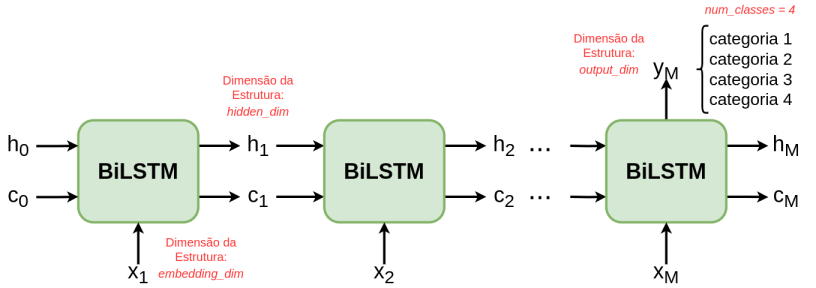

In [59]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers=1,bidirectional=True,batch_first=True) # diz que a primeira dimensao eh o batch_size
        self.fcl = nn.Linear(hidden_dim,output_dim)

    def forward(self,text): # text = [[1,5,8,0,3,6],[8,9,1,12,34,7]] #qtde = batch_size
        embedded = self.embedding(text) #entra estrutura nas dimensoes [batch_size x max_len]
        lstm, (hidden, cell_state) = self.lstm(embedded) #sai estrutura nas dimensoes [batch_size x hidden_dim]
        outputs = self.fcl(hidden[-1,:,:]) #pega o ultimo estado interno da LSTM - suficiente para classificacao
        return outputs

Primeira parte, coletar os dados:

In [60]:
cats = ['comp.graphics', 'talk.politics.misc','rec.autos','sci.electronics']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroups_test = fetch_20newsgroups(subset='test', categories=cats)

Separação dos Dados da estrutura newsgroups_train e newsgroups_test:

In [61]:
train_sentences = newsgroups_train.data
train_labels = newsgroups_train.target

test_sentences = newsgroups_test.data
test_labels = newsgroups_test.target

Pré-Processamento das sentenças de treinamento e de teste

In [62]:
def preprocess(X):
    Xl = []
    for sentence in X:
        result = re.sub(r'\n',' ',sentence)
        result = re.sub(r'[^\w\s]','',result) #remove os simbolos de pontuacao
        result = result.lower()
        Xl.append(result)
    return Xl

In [63]:
train_preproc_sentences = preprocess(train_sentences)
test_preproc_sentences = preprocess(test_sentences)

Construção do Vocabulário a partir das Sentenças de Treinamento

In [64]:
 # <OOV>: palavra especial out of vocabulary: quando uma palavra de teste nao existe no vocabulario de treino
 # <PAD>: palavra associada ao padding
word2index = {'<PAD>' : 0, '<OOV>':1 }

for sentence in train_preproc_sentences:
    for word in sentence.split():
        if word not in word2index:
            word2index[word.lower()] = len(word2index)

vocab_size = len(word2index)

In [65]:
word2index

{'<PAD>': 0,
 '<OOV>': 1,
 'from': 2,
 'tommybooleattcom': 3,
 'tommy': 4,
 'reingold': 5,
 'subject': 6,
 're': 7,
 'improvements': 8,
 'in': 9,
 'automatic': 10,
 'transmissions': 11,
 'replyto': 12,
 'organization': 13,
 'att': 14,
 'bell': 15,
 'labs': 16,
 'holmdel': 17,
 'nj': 18,
 'usa': 19,
 'originator': 20,
 'tommyhoodlum': 21,
 'keywords': 22,
 'saturn': 23,
 'subaru': 24,
 'manual': 25,
 'nntppostinghost': 26,
 'hoodluml1135attcom': 27,
 'lines': 28,
 '24': 29,
 'hagenjdwfuedu': 30,
 'jeff': 31,
 'hagen': 32,
 'writes': 33,
 'the': 34,
 'biggest': 35,
 'hurdle': 36,
 'for': 37,
 'automatics': 38,
 'imho': 39,
 'is': 40,
 'not': 41,
 'shifting': 42,
 'speed': 43,
 'per': 44,
 'se': 45,
 'but': 46,
 'rather': 47,
 'reaction': 48,
 'when': 49,
 'you': 50,
 'try': 51,
 'to': 52,
 'force': 53,
 'it': 54,
 'shift': 55,
 'manually': 56,
 'i': 57,
 'rented': 58,
 'an': 59,
 'oldsmobile': 60,
 'achieva': 61,
 'that': 62,
 'a': 63,
 'yuppie': 64,
 'name': 65,
 'or': 66,
 'what': 67,


Converte as palavras de cada sentença dos dados de treinamento e de teste para números inteiros (numericalização) e, em seguida, faz o **padding**, em que todas as sentenças terão ```max_len``` de tamanho.

```max_len``` é um valor que deve ser ajustado manualmente!

In [66]:
def encoding(X,vocab,max_len):

    sentences_encoding = []

    for i in range(len(X)):
        sentence = X[i].split()
        encoded_sentence = []
        for j in range(0,min(len(sentence),max_len)):
            if sentence[j] in vocab:
                encoded_sentence.append(vocab[sentence[j]])
            else:
                encoded_sentence.append(vocab['<OOV>']) # se palavra nao estiver no vocabulario, colocar o indice da palavra especial OOV

        if max_len > len(sentence):
            tam = max_len-len(sentence)
            zeros = [vocab['<PAD>']]*tam
            encoded_sentence.extend(zeros)

        sentences_encoding.append(np.array(encoded_sentence))

    return np.array(sentences_encoding)

Ajusta o padding das sentenças. Todas elas terão 256 palavras. Caso uma sentença tenha menos do que 256 palavras, as posições remanescentes são preenchidas com valor zero.

In [67]:
max_len = 128

In [68]:
train_integer_values = encoding(train_preproc_sentences,word2index,max_len)
test_integer_values = encoding(test_preproc_sentences,word2index,max_len)

Resultado do padding: vetores com tamanho maximo de 256

In [69]:
len(train_integer_values[1])

128

e todas as palavras foram convertidas para números:

In [70]:
train_integer_values[1]

array([  2, 139, 140, 141,   6, 142, 143, 144, 145, 146, 147, 148,  22,
       142, 143, 147, 148,  13, 149, 150, 151, 152, 153,  28, 154, 155,
       156,  57,  77,  63, 157, 158, 159,  52, 160, 161,   9, 162, 163,
       164, 165,  34, 166, 167,  37, 168,  46,  57, 169, 170, 116, 171,
       172,  34, 173, 174, 175,  54, 176, 159, 177, 178,  57, 146, 179,
       180, 181, 182, 181, 183,  66, 184, 185,  62,  57,  77,  79, 116,
       144, 145,  66, 147,  57,  77,  63, 142, 186, 187, 188, 142, 189,
       190, 191,  62, 192, 179, 163, 193, 194,  37,  34, 142,  68, 123,
       195,  52, 146, 196, 197,  34, 198,  57,  77, 199, 136,  63, 200,
       201,  37, 179, 202,  66, 203,  62,  50, 204,  77,  63])

Colocamos agora os dados de treinamento e de teste dentro de DataLoaders

Hiperparâmetros da BiLSTM

In [71]:
INPUT_DIM = vocab_size
LEARNING_RATE = 5e-4
EMBEDDING_DIM = 128
HIDDEN_DIM = 512
OUTPUT_DIM = num_classes
BATCH_SIZE = 32

In [72]:
train_dataset = TextDataSet(train_integer_values, train_labels)
test_dataset = TextDataSet(test_integer_values, test_labels)

train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset,batch_size = BATCH_SIZE)

Veja agora a instanciação do modelo e sua arquitetura final:

In [73]:
model = LSTM(INPUT_DIM,EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM)
model

LSTM(
  (embedding): Embedding(37545, 128)
  (lstm): LSTM(128, 512, batch_first=True, bidirectional=True)
  (fcl): Linear(in_features=512, out_features=4, bias=True)
)

Criamos a seguir a função loss como sendo Entropia Cruzada e o otimizador (implementa o backpropagation via cálculo de matriz - Adam):

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [75]:
NUM_EPOCHS = 15

In [76]:
for epoch in range(NUM_EPOCHS):

    model.train() # ativa o modo de treinamento

    total_loss = 0

    for X_batch,y_batch in train_loader:

        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred,y_batch) # o valor inteiro dos labels de y_train sao automaticamente convertidos para one hot encoding

        loss.backward() # calcula os gradientes

        optimizer.step() # atualiza os parametros do modelo

        total_loss += loss.item()

    print(f'Epoch {epoch} ============== Train Loss: {total_loss/len(X_batch)}')

Epoch 0 ============== Train Loss: 3.3968219940478983
Epoch 1 ============== Train Loss: 2.184845112837278
Epoch 2 ============== Train Loss: 1.3942103769916754
Epoch 3 ============== Train Loss: 0.8486929312348366
Epoch 4 ============== Train Loss: 0.5657398190635902
Epoch 5 ============== Train Loss: 0.32674956199927974
Epoch 6 ============== Train Loss: 0.23791918869560155
Epoch 7 ============== Train Loss: 0.21219569268690136
Epoch 8 ============== Train Loss: 0.09085499022890312
Epoch 9 ============== Train Loss: 0.11746256304412292
Epoch 10 ============== Train Loss: 0.045770935056050524
Epoch 11 ============== Train Loss: 0.10006360372510524
Epoch 12 ============== Train Loss: 0.02366721266970182
Epoch 13 ============== Train Loss: 0.007572811831778381
Epoch 14 ============== Train Loss: 0.0034920762832021304


Avaliação com os dados de teste

In [77]:
y_pred = []
y_test = []
for text, label in test_loader:
    y_prob = model(text)
    _, predicted = torch.max(y_prob, 1)
    y_pred.extend(predicted.tolist())
    y_test.extend(label.tolist())

Resultados nos dados de teste:

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.87      0.69       389
           1       0.66      0.65      0.66       396
           2       0.68      0.51      0.59       393
           3       0.89      0.63      0.73       310

    accuracy                           0.67      1488
   macro avg       0.70      0.67      0.67      1488
weighted avg       0.69      0.67      0.66      1488

